In [112]:
# Use of libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split as split
from sklearn import preprocessing
import warnings
from sys import modules
warnings.filterwarnings('ignore')
%matplotlib inline

##**Airline fare - EDA and Prediction**

Our data set contains information about flights and details such as date, route and destination,
And we want to predict the price of the flight.
The data are on flights in India, during the year 2019.

Given that flight prices today are unpredictablee, we will try to check what factors affect the prices of airline tickets.

And perform price prediction using Linear Regression, KNN and Decision Tree Regressor.

The data set was taken from Kagel.


####**Loadind the Data and some info**

In [543]:
airline_data = pd.read_csv('Airline_fare.csv')

In [544]:
airline_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR ? DEL,22:20,22/03/2022 01:10,2h 50m,non-stop,No info,3898
1,Air India,01/05/2019,Kolkata,Banglore,CCU ? IXR ? BBI ? BLR,05:50,13:15,7h 25m,2 stops,No info,7663
2,Jet Airways,09/06/2019,Delhi,Cochin,DEL ? LKO ? BOM ? COK,09:25,10/06/2022 04:25,19h,2 stops,No info,13883
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU ? NAG ? BLR,18:05,23:30,5h 25m,1 stop,No info,6219
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR ? NAG ? DEL,16:50,21:35,4h 45m,1 stop,No info,13303


In [545]:
airline_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


####**Dealing with missing and duplicated values**

In [546]:
# chaking nan values
airline_data.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional Info    0
Price              0
dtype: int64

In [547]:
# there is only one row with null we decide to drop it
airline_data[airline_data['Route'].isnull() == True] # only row index 9039 is null also for Total_Stops
airline_data.dropna(axis='rows', inplace=True)

In [548]:
# chacking duplicated row 
a  = airline_data.duplicated().sum() 
print(f'There are {a} duplicated rows, we decide to drop them from the data.')
airline_data.drop_duplicates(keep= 'first', inplace=True)

There are 220 duplicated rows, we decide to drop them from the data.


In [549]:
airline_data.duplicated().sum()

0

####**EDA and Data Preprocessing**

Flights by airlines -

We compare the total flights by airlines for this data set.
after we saw that there is same airline company but with a different budget we decide to add another column with the airline budget.

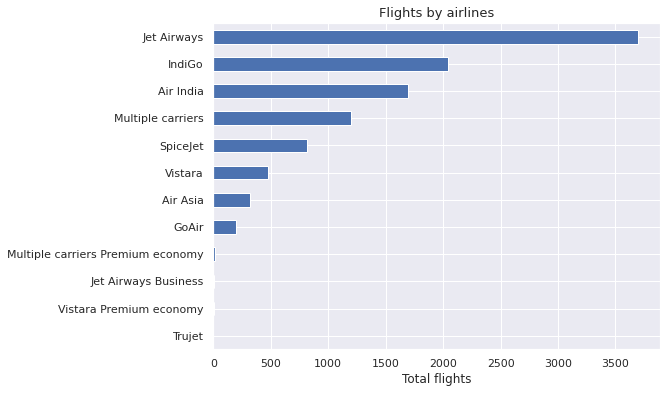

In [550]:
plt.figure(figsize=(8,6))
sns.set(style="darkgrid")
airline_data['Airline'].value_counts().sort_values(ascending=True).plot(kind ='barh')
plt.title('Flights by airlines', fontsize=13)
plt.xlabel('Total flights')
plt.show()

In [551]:
# splitting the departure time to hours and minutes
airline_data['dept_hour'] =  pd.to_datetime(airline_data.Dep_Time).dt.hour
airline_data['dept_min'] = pd.to_datetime(airline_data.Dep_Time).dt.minute

In [552]:
# changning the dept time to period
airline_data['Dep_Time'] = pd.to_datetime(airline_data["Dep_Time"]).dt.hour
def changing_hour_dpet(row):
  if row in [4,5,6,7]:
    return 'Early Morning'
  elif row in [8,9,10,11] :
    return 'Morning'
  elif row in [12,13,14,15] :
    return 'Noon'
  elif row in [16,17,18] :
    return 'Afternoon'
  elif row in [19,20,21,22] :
    return 'Evening'
  elif row in [23,0,1,2,3]:
    return 'Night'

airline_data['Dep_Time'] = airline_data['Dep_Time'].apply(changing_hour_dpet)

Mean price by dep time -

We decide to use Log Transform technique, to convert the distribution to a normal distribution.

we took the log of the prices and use these values as the column price.

we can see that the price is more high in the afternoon and morning time.
also the lower price is the night time, we sow that there is less flights in the night. 

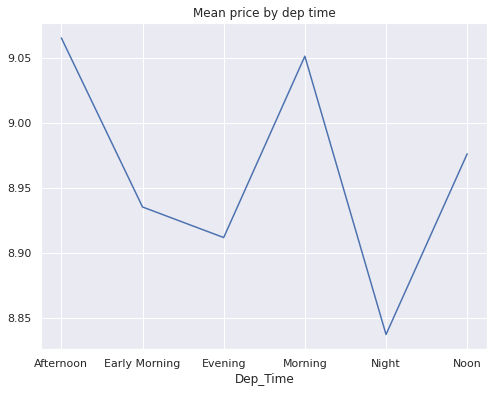

<Figure size 432x288 with 0 Axes>

In [553]:
# Log Transform changing the price to log for normalization and skala
airline_data['log_price'] = np.log1p(airline_data.Price)
airline_data.drop('Price', axis = 'columns', inplace = True)

plt.figure(figsize=(8,6))
sns.set(style="darkgrid")
airline_data.groupby('Dep_Time')['log_price'].mean().plot()
plt.title('Mean price by dep time')
plt.show()
# save the figure plt. 
plt.savefig('mean price by dept.png')

Distribution Price

The price of 50% from the flights in our data set is around 8200-9000 in Indian currency.

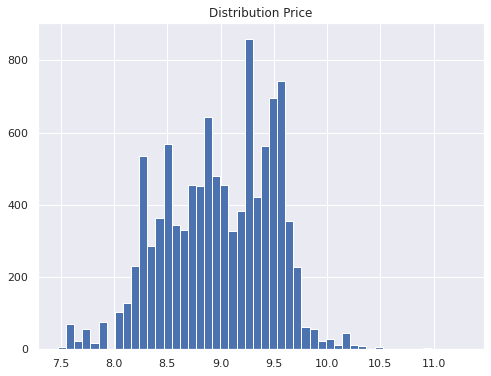

<Figure size 432x288 with 0 Axes>

In [554]:
plt.figure(figsize=(8,6))
airline_data.log_price.hist(bins=50)
plt.title('Distribution Price')
plt.show()
plt.savefig('Dist Price.png')

Price Describe

In [555]:
np.expm1(airline_data['log_price']).describe()

count    10462.000000
mean      9027.790289
std       4624.849541
min       1760.000000
25%       5225.000000
50%       8267.000000
75%      12345.750000
max      79513.000000
Name: log_price, dtype: float64

In [556]:
# changing the total_stops column to int type
airline_data = (airline_data.replace("non-stop", 0).replace("1 stop", 1).replace("2 stops", 2).replace("3 stops", 3).replace("4 stops", 4))

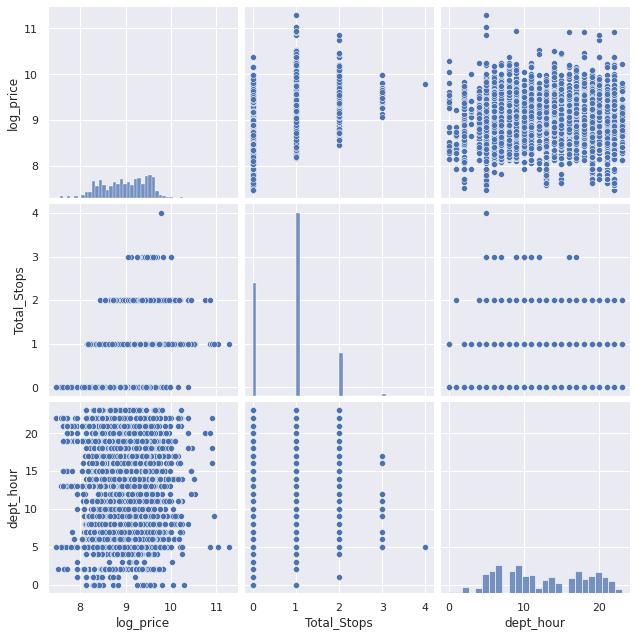

In [557]:
sns.pairplot(airline_data[['log_price','Total_Stops', 'Duration','dept_hour']], height=3)
# plt.savefig('pairplot Price.png')
plt.show()

Since the data contains flights from many different airlines, but not in a balanced way, we chose to categorize the companies into 3 categories and present the information - low cost, full service and business class.

In [558]:
def change_airline(row):
  if row in ['IndiGo', 'SpiceJet', 'Air Asia', 'GoAir', 'Trujet'] :
    return 'low_cost'
  if row in ['Jet Airways','Vistara', 'Air India', 'Multiple carriers']:
    return 'full_service'
  if row in ['Jet Airways Business', 'Multiple carriers Premium economy' ,'Vistara Premium economy']:
    return 'business'

airline_data['Airline_budget'] = airline_data['Airline'].apply(change_airline)


After splitting into the airline budget, most flights (60%) are full service, 30% low cost and the rest in business class.

and here we can see the mean price by airline budget.

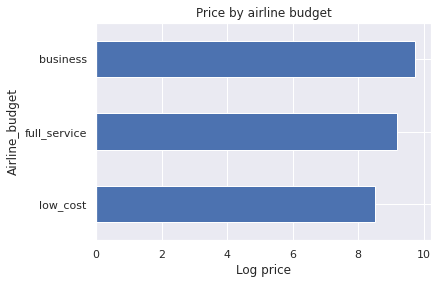

In [559]:
airline_data.groupby('Airline_budget')['log_price'].mean().sort_values(ascending=True).plot(kind='barh')
plt.title('Price by airline budget')
plt.xlabel('Log price')
plt.show()

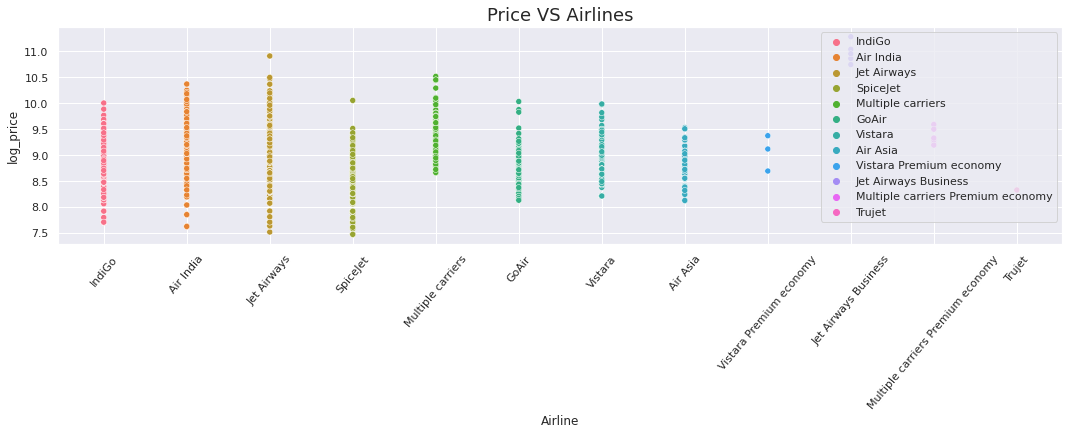

In [560]:
plt.figure(figsize=(18 ,4))
sns.scatterplot(data=airline_data,
                x="Airline", y="log_price", hue="Airline")
plt.title('Price VS Airlines', fontsize=18)
plt.xticks(rotation = 50)
plt.legend(loc='upper right')
plt.show()

Price by month

Our data set not contain flights in all the year months.
in April there is less flights then the other months (maybe the reason is because India holidays) and there is small decrease in the price for this month.


In [561]:
# adding separate columns of day, month and year
airline_data['day'] =  pd.to_datetime(airline_data.Date_of_Journey).dt.day
airline_data['month'] = pd.to_datetime(airline_data.Date_of_Journey).dt.month
airline_data['year'] =  pd.to_datetime(airline_data.Date_of_Journey).dt.year
airline_data.drop(columns=['Date_of_Journey','year'], axis='columns', inplace= True)

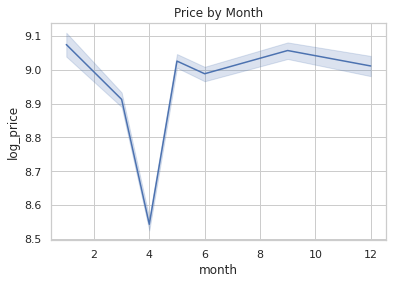

In [562]:
sns.set_theme(style="whitegrid")
ax = sns.lineplot(x='month', y='log_price', data=airline_data)
plt.title('Price by Month')
plt.show()

Distribution flights by stops -

More than 50% from the flights in our data is with one stop.

and 33% from our data is direct flights.

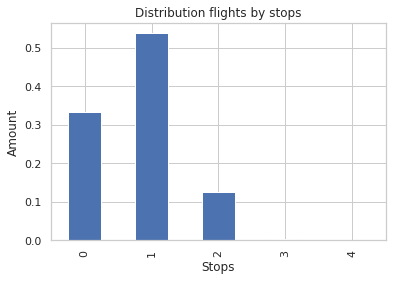

In [563]:
airline_data['Total_Stops'].value_counts(normalize=True).sort_index().plot(kind='bar')
plt.title('Distribution flights by stops')
plt.xlabel('Stops')
plt.ylabel('Amount')
plt.show()

In [564]:
# chanage Duration to minute 
airline_data['Duration'] = (pd.to_timedelta(airline_data['Duration']).dt.seconds // 60).astype(int)

In [565]:
airline_data.groupby('Total_Stops')['Duration'].mean()

Total_Stops
0    149.991367
1    627.060444
2    752.454476
3    609.186047
4    330.000000
Name: Duration, dtype: float64

####**Detecting Outliers**

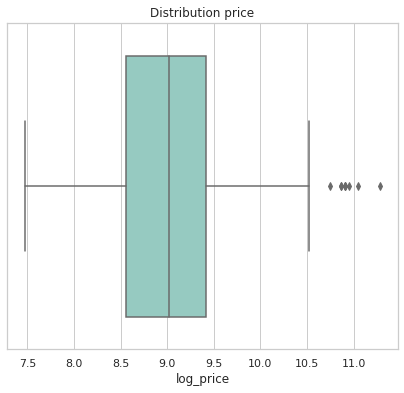

In [566]:
  # check outliers fo price
  plt.figure(figsize=(7,6))
  ax = sns.boxplot(x=airline_data["log_price"], palette="Set3").set_title('Distribution price')

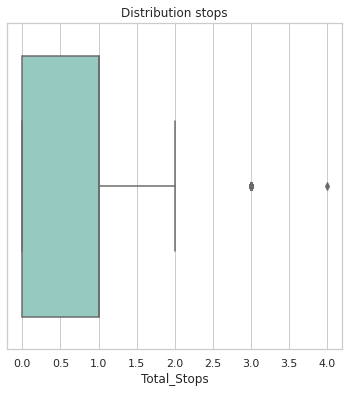

In [567]:
  # check outliers fo stops
  plt.figure(figsize=(6,6))
  ax = sns.boxplot(x=airline_data['Total_Stops'], palette="Set3").set_title('Distribution stops')

In [568]:
# moving outliers for price
airline_data = airline_data[airline_data['log_price'] < 10.5]

In [569]:
a,b = airline_data.shape
print(f'The final data for the model contain {a} rows and {b} columns.')

The final data for the model contain 10452 rows and 15 columns.


###**Feature engineering and Preparing data for the model**

In [570]:
# dropping irrelevant columns
airline_data.drop(columns=['Airline','Additional Info','Arrival_Time','dept_min'], axis='columns', inplace=True)

In [571]:
a,b = airline_data.shape
print(f'The data for now is {a} rows and {b} columns')

The data for now is 10452 rows and 11 columns


In [572]:
# # option 1 for dealing with route column
airline_data[['R0','R1','R2','R3','R4','R5']] = airline_data['Route'].str.split('?', expand = True)
airline_data = airline_data.fillna('None')
airline_data.drop('Route', axis='columns', inplace= True)

In [574]:
airline_dummies = airline_data.copy()
airline_dummies.drop(columns=['R0','R5','R4'], axis='columns', inplace=True)
airline_dummies.head(3)

,Source,Destination,Dep_Time,Duration,Total_Stops,dept_hour,log_price,Airline_budget,day,month,R1,R2,R3
0,Banglore,New Delhi,Evening,170,0,22,8.268475,low_cost,24,3,DEL,None,None
1,Kolkata,Banglore,Early Morning,445,2,5,8.944289,full_service,5,1,IXR,BBI,BLR
2,Delhi,Cochin,Morning,1140,2,9,9.538492,full_service,6,9,LKO,BOM,COK


In [575]:
# Dealing with category columns
category_coulmns = ['Airline_budget','Source','Destination','Dep_Time','R1','R2','R3']
def category_change(name) :
    name = pd.get_dummies(airline_dummies[name], drop_first= True)
    return name
# Airline = category_change('Airline')
Destination = category_change('Destination')
Dep_Time = category_change('Dep_Time')
Airline_budget = category_change('Airline_budget')
Source = category_change('Source')
# R0 = category_change('R0')
R1 = category_change('R1')
R2 = category_change('R2')
R3 = category_change('R3')
# R4 = category_change('R4')
# R5 = category_change('R5')
airline_dummies.drop(columns=category_coulmns, inplace=True)

In [ ]:
airline_dummies = pd.concat([airline_dummies,Airline_budget,Source,Destination,Dep_Time,R1,R2,R3], axis=1)
airline_dummies.head()

###**Linear Regression Model**

In this model we used dummies for the categories columns.






In [577]:
# function to transform from log price to real price
def transrome_logprice(columnreal, columnpred ):
  a =  np.expm1(columnreal)
  b =  np.expm1(columnpred)
  rmse = mean_squared_error(y_true=a, 
                          y_pred=b, 
                          squared=False)
  return rmse

In [578]:
fare_train, fare_test = split(airline_dummies, test_size=0.3, 
                              random_state=123456)
def train_test(df):
  X_train = fare_train.drop('log_price', axis=1)
  y_train = fare_train['log_price']
  X_test = fare_test.drop('log_price', axis=1)
  y_test = fare_test['log_price']
  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test(airline_dummies)


print(f'Train size:\nInput-> {X_train.shape}, Output-> {y_train.shape[0]}')
print(f'Test size:\nInput-> {X_test.shape} Output-> {X_test.shape[0]}')
print("~"*40)

fare_lm = LinearRegression().fit(X_train, y_train)
print(f'''The intercept is {fare_lm.intercept_:.3f}\nand the coefficient is {list(zip(X_train.columns, fare_lm.coef_))} ''')

def model_lr(X_train, y_train, df=fare_train):
  df['price pred.'] = fare_lm.predict(X_train)
  # print(f'Score of train is: {fare_lm.score(X_train, y_train):.3f}')
  rmse = mean_squared_error(y_true=df['log_price'], 
                          y_pred=df['price pred.'], 
                          squared=False)
  print(f"The RMSLE is = {rmse:.4f}")
  # return df['price pred.']

# function to transform from log price to real price
def transrome_logprice(columnreal, columnpred ):
  a =  np.exp(columnreal)
  b =  np.exp(columnpred)
  rmse = mean_squared_error(y_true=a, 
                          y_pred=b, 
                          squared=False)
  return rmse

print("~"*40)
print('Result for train :')
model_lr(X_train, y_train)
train_rmse = transrome_logprice(y_train, fare_train['price pred.'] )
print(f'The rmse is = {train_rmse:.3f}')
print("~"*40)
print('Result for test :')
model_lr(X_test, y_test, df=fare_test)
test_rmse = transrome_logprice(y_test, fare_test['price pred.'] )
print(f'The rmse is = {test_rmse:.3f}')


Train size:
Input-> (7316, 107), Output-> 7316
Test size:
Input-> (3136, 107) Output-> 3136
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
The intercept is 8.655
and the coefficient is [('Duration', 2.76421183594411e-05), ('Total_Stops', 0.32916955084868915), ('dept_hour', 0.0017460814286804627), ('day', -0.0064746128709068235), ('month', -0.005459507978554004), ('full_service', -0.07426730684090216), ('low_cost', -0.41186967352980997), ('Chennai', 0.012850110501915818), ('Delhi', 0.10993866101985221), ('Kolkata', 0.014582724196450153), ('Mumbai', 0.018241686231075027), ('Cochin', 0.10993866101983524), ('Delhi', -0.2625222155500551), ('Hyderabad', 0.018241686231079544), ('Kolkata', 0.012850110501918442), ('New Delhi', 0.10690903360075069), ('Early Morning', -0.019494509909494993), ('Evening', -0.058207126760660075), ('Morning', -0.0010944819656347853), ('Night', 0.03910625359478991), ('Noon', -0.026089640464129926), (' ATQ ', 0.23593732187084637), (' BBI ', -0.08197123351755964), (' BDQ ', -

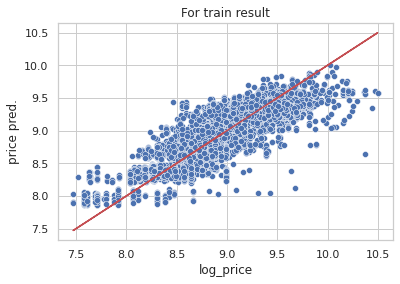

In [238]:
ax = sns.scatterplot(x=y_train, y=fare_train['price pred.'])
ax.plot(y_train, y_train, 'r')
plt.title('For train result')
plt.show()

In [239]:
# Sample price  prediction
print('Sample price prediction-  train')
pd.DataFrame({'Real_price':fare_train['log_price'],'Prdict_price':fare_train['price pred.']}).head(3)

Sample price prediction-  train


,Real_price,Prdict_price
9544,9.464983,9.264633
3246,9.624963,9.369355
8401,8.833754,8.840675


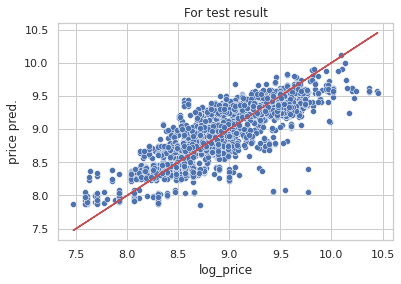

In [240]:
ax = sns.scatterplot(x=y_test, y=fare_test['price pred.'])
ax.plot(y_test,y_test, 'r')
plt.title('For test result')
plt.show()

In [241]:
# Sample price  prediction
print('Sample price prediction-  test')
pd.DataFrame({'Real_price':fare_test['log_price'],'Prdict_price':fare_test['price pred.']}).head(3)

Sample price prediction-  test


,Real_price,Prdict_price
3655,9.538492,9.521841
3514,9.624501,9.436867
3630,9.501217,9.306150




> **Predicted vs. Actual**




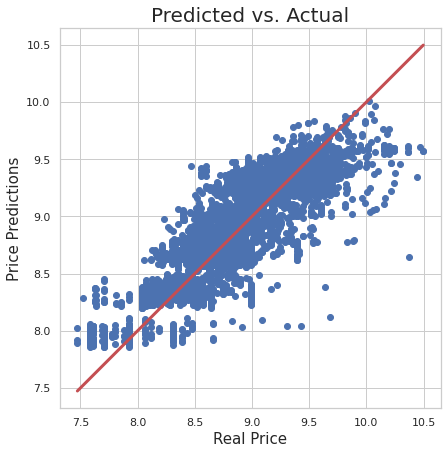

In [242]:
plt.figure(figsize=(7,7))
plt.scatter(y_train, fare_train['price pred.'])
# plt.yscale('log')
# plt.xscale('log')
p1 = max(max(y_train), max(fare_train['price pred.']))
p2 = min(min(y_train), min(fare_train['price pred.']))
plt.plot([p1, p2], [p1, p2], 'r', linewidth=3)
plt.xlabel('Real Price', fontsize=15)
plt.ylabel('Price Predictions', fontsize=15)
plt.axis('equal')
plt.axis('square')
plt.title('Predicted vs. Actual', fontsize=20)
plt.show()

###**KNN Model**

In [468]:
knn_data = airline_data.copy()
knn_data.drop(columns=['R0','R5'], axis='columns', inplace=True)

In [469]:
knn_data.head()
knn_data.drop('Dep_Time', axis='columns', inplace=True)
knn_data.head()

,Source,Destination,Dep_Time,Duration,Total_Stops,dept_hour,log_price,Airline_budget,day,month,R1,R2,R3,R4
0,Banglore,New Delhi,Evening,170,0,22,8.268475,low_cost,24,3,DEL,None,None,None
1,Kolkata,Banglore,Early Morning,445,2,5,8.944289,full_service,5,1,IXR,BBI,BLR,None
2,Delhi,Cochin,Morning,1140,2,9,9.538492,full_service,6,9,LKO,BOM,COK,None
3,Kolkata,Banglore,Afternoon,325,1,18,8.735525,low_cost,5,12,NAG,BLR,None,None
4,Banglore,New Delhi,Afternoon,285,1,16,9.495820,low_cost,3,1,NAG,DEL,None,None


In [ ]:
#@title
# scaling the data
ml = StandardScaler()
# ml = MinMaxScaler()
ds = knn_data.drop('log_price', axis=1)
y = knn_data['log_price']
dataset = ml.fit_transform(ds)
k_data = pd.DataFrame(dataset,columns= ds.columns)
k_data.shape,y.shape

In [470]:
#@title
conver_source = {'Banglore':1, 'Kolkata':2, 'Delhi':3, 'Chennai':4, 'Mumbai':5}
conver_Destination = {'New Delhi':6, 'Banglore':1, 'Cochin':8, 'Kolkata':9, 'Delhi':3,'Hyderabad':11}
knn_data['Source'] = knn_data['Source'].map(conver_source)
knn_data['Destination'] = knn_data['Destination'].map(conver_Destination)

In [ ]:
#@title
def category_change(name) :
    name = pd.get_dummies(knn_data[name], drop_first= True)
    return name
Airline = category_change('Airline')
Dep_Time = category_change('Dep_Time')
Airline_budget = category_change('Airline_budget')
Destination = category_change('Destination')
Source = category_change('Source')
R5 = category_change('R2')
R5 = category_change('R3')
knn_data.drop(columns=['Airline','Dep_Time','Airline_budget','Destination','Source','R2','R3'], inplace=True)
knn_data = pd.concat([knn_data,Airline,Dep_Time,Airline_budget,Destination,Source], axis=1)
knn_data.head()

In [473]:
#@title
# encoding aicategorail columns to int
def encoding_columns(columnname):
  le = preprocessing.LabelEncoder()
  le.fit(list(knn_data[columnname].unique()))
  le.classes_
  knn_data[columnname] = le.transform(knn_data[columnname])

listis_encoding = ['Dep_Time','Airline_budget','Source','Destination']
for name in listis_encoding:
  encoding_columns(name)

In [ ]:
#@title
# option 1 for dealing with route column
# airline_data[['0','1','2','3','4','5']] = airline_data['Route'].str.split('?', expand = True)
# airline_data = airline_data.fillna(0)
all_airports = {}
for ls in ['R1','R2','R3','R4']:
  for i in list(knn_data[ls].unique()):
    all_airports[i] = 0
l = list(all_airports.keys())
dict_air = dict(enumerate(l, start=1))
dict_air
new = {}
for k,v in dict_air.items() :
  new[v] = k
new['None'] = 0
print(new)
for ls in ['R1','R2','R3','R4']:
  knn_data[ls] = knn_data[ls].replace(new, regex= True)



In [494]:
X_train, X_test,y_train,y_test = split(k_data,y, test_size=0.3, 
                              random_state=123456)

In [486]:
#@title
# # first option
# fare_train, fare_test = split(airline_dummies, test_size=0.3, 
#                               random_state=123456)
# def train_test(df):
#   X_train = fare_train.drop('log_price', axis=1)
#   y_train = fare_train['log_price']
#   X_test = fare_test.drop('log_price', axis=1)
#   y_test = fare_test['log_price']
#   return X_train, X_test, y_train, y_test

# X_train, X_test, y_train, y_test = train_test(airline_dummies)

In [500]:
knn_model = KNeighborsRegressor(n_neighbors=8).fit(X_train, y_train)
y_train_pred = knn_model.predict(X_train)
# fare_train['price pred.'] = knn_model_1.predict(X_train)

In [501]:
price_error = transrome_logprice(y_train, y_train_pred)
RMSE = mean_squared_error(y_train, y_train_pred, squared=False)
print(f'The RMSLE is {RMSE:.3f}')
print(f"The RMSE is = {price_error:.3f}")

The RMSLE is 0.215
The RMSE is = 2173.774


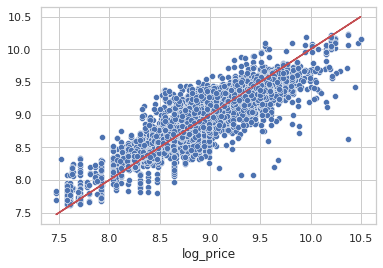

In [502]:
ax = sns.scatterplot(y_train, y_train_pred)
ax.plot(y_train,y_train, 'r')
plt.show()

Checking in the range of 15 neighbors where we will get the best result for verification, we can see that in number 9 the lowest error.

In [503]:
# chaking with loop where we wiil get the best rmase for validation
rmse_list = [] 
for K in range(1,15):
    model = KNeighborsRegressor(n_neighbors = K).fit(X_train, y_train)
    y_test_pred =model.predict(X_test) 
    error = mean_squared_error(y_test,y_test_pred, squared=False) 
    rmse_list.append(error) 
    print(f'RMSE value for k = {K:^3} is: {error}')

RMSE value for k =  1  is: 0.30701020992980776
RMSE value for k =  2  is: 0.26344770219995234
RMSE value for k =  3  is: 0.25013323386000413
RMSE value for k =  4  is: 0.24872166236100274
RMSE value for k =  5  is: 0.2455525645260885
RMSE value for k =  6  is: 0.2454527261233435
RMSE value for k =  7  is: 0.24499443373956065
RMSE value for k =  8  is: 0.24455069819304076
RMSE value for k =  9  is: 0.2447029118165222
RMSE value for k = 10  is: 0.24543706326189652
RMSE value for k = 11  is: 0.24724783156385455
RMSE value for k = 12  is: 0.24798679322175057
RMSE value for k = 13  is: 0.24925427920309148
RMSE value for k = 14  is: 0.24913423023644815


In [504]:
# validation - run the model in test dat
y_test_pred = knn_model.predict(X_test)
price_test_error = transrome_logprice(y_test, y_test_pred)
RMSE = mean_squared_error(y_test, y_test_pred, squared=False)
print(f'The RMSLE is {RMSE:.3f}')
score= knn_model.score(X_test, y_test)
print(f"The RMSE is = {price_test_error:.3f}")

The RMSLE is 0.245
The RMSE is = 2393.992


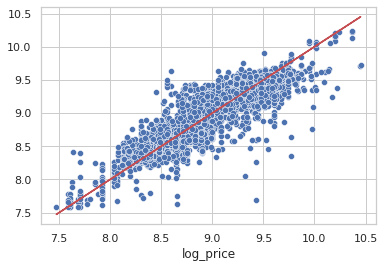

In [ ]:
ax = sns.scatterplot(y_test, y_test_pred)
ax.plot(y_test,y_test, 'r')
plt.show()

###**Decision Tree Regressor Model** 

In [412]:
fare_train, fare_test = split(airline_dummies, test_size=0.3, 
                              random_state=123456)
def train_test(df):
  X_train = fare_train.drop('log_price', axis=1)
  y_train = fare_train['log_price']
  X_test = fare_test.drop('log_price', axis=1)
  y_test = fare_test['log_price']
  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test(airline_dummies)

In [413]:
X_train, X_test,y_train,y_test = split(k_data,y, test_size=0.3, 
                              random_state=123456)

In [414]:
dt_model= DecisionTreeRegressor(max_leaf_nodes=40,min_samples_leaf=0.01).fit(X_train, y_train)

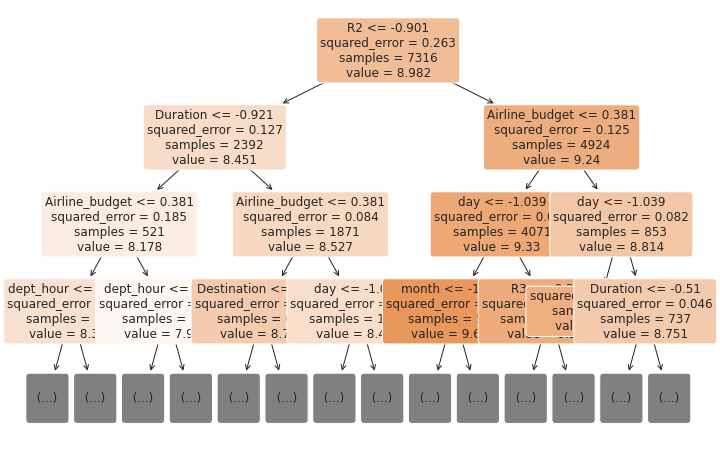

In [415]:
def visualize_tree(model, md=5, fs=(12, 8)):
    plt.figure(figsize=fs)
    plot_tree(model,
            max_depth=md,
            feature_names=model.feature_names_in_,
            label='all',
            filled=True,
            rounded=True, 
            fontsize=12);
visualize_tree(dt_model, md=3)

In [416]:
y_train_pred = dt_model.predict(X_train)

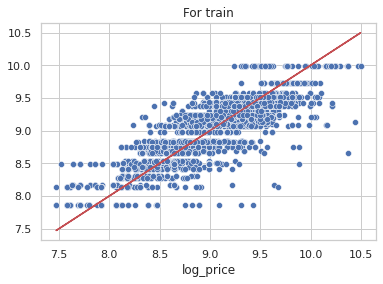

In [417]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')
plt.title('For train')
plt.show()

In [418]:
price_error = transrome_logprice(y_train, y_train_pred)
RMSE = mean_squared_error(y_train, y_train_pred, squared=False)
print(f'The RMSLE is {RMSE:.3f}')
print(f"The RMSE is = {price_error:.3f}")

The RMSLE is 0.225
The RMSE is = 2226.329


In [419]:
# validation model
y_test_pred = dt_model.predict(X_test)
price_test_error = transrome_logprice(y_test, y_test_pred)
RMSE = mean_squared_error(y_test, y_test_pred, squared=False)
print(f'The RMSLE is {RMSE:.3f}')
score= dt_model.score(X_test, y_test)
# print(f'The score is {score:.3f}')
print(f"The RMSE is = {price_test_error:.3f}")

The RMSLE is 0.232
The RMSE is = 2231.822


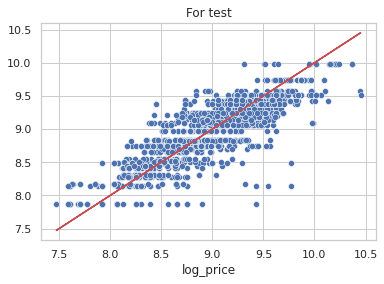

In [420]:
ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_test, y_test, 'r')
plt.title('For test')
plt.show()

###**Best Result we got**

In [422]:
#@title
# Comparing all the models
models = pd.DataFrame({
    'Model': ['Linear Regression','Decision Tree Regressor(min_samples_leaf=0.01)', 'KNN (K=9)'],
    'Test RMSE': [ 2490,2241, 2466],
    'Train RMSE': [2571, 2255, 2381]}, index= ['LR','DT','KNN'])
models.sort_values(by='Test RMSE', ascending=True)

,Model,Test RMSE,Train RMSE
DT,Decision Tree Regressor(min_samples_leaf=0.01),2241,2255
KNN,KNN (K=9),2466,2381
LR,Linear Regression,2490,2571


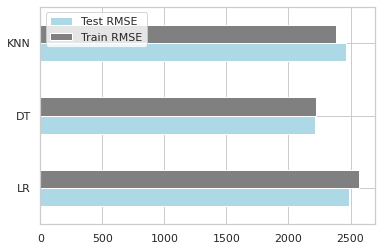

In [ ]:
#@title
models.plot(kind='barh',color = ('lightblue','grey'))
plt.legend(loc='upper left')
plt.show()

##**Summary of results:**


> Linear Regression

```
Result for train :
Score = 0.769
RMSE = 2571.193
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Result for test :
Score = 0.765
RMSE = 2490.582
```

> KNeighbors Regressor

```
Result for train :
Score = 0.838
RMSE = 2381.332
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Result for test :
Score = 0.792
RMSE = 2466.473
```

> Decision Tree Regressor

```

Result for train :
Score = 0.805
RMSE = 2255.295
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Result for test :
Score = 0.792
RMSE = 2241.257

```

